# Trabajo Práctico 6 - Procesamiento de Lenguaje Natural

## Asociación de palabras

### 1. Levantar el corpus AP, separando cada noticia como un elemento distinto en un diccionario (DOCNO:TEXT)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import nltk
from nltk import FreqDist
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from urllib import request
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from io import StringIO
import xml.etree.ElementTree as etree



nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/nico/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nico/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/nico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nico/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
diccionario = {}
with open('ap.txt', 'rb') as apfile:

    ap89_plain = apfile.read().decode('utf-8')

    ap89_plain = '<DOCS>\n' + ap89_plain + '</DOCS>\n'
    ap89_plain = ap89_plain.replace('&', '&#038;')
    ap89_IO = StringIO(ap89_plain)
    tree = etree.parse(ap89_IO)
    root = tree.getroot()
    
    for child in root:
        diccionario[child[0].text] = child[1].text



In [3]:
def gwp(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [4]:
def limpiar(t):
    stop = set(stopwords.words('english'))
    
    sent = nltk.sent_tokenize(t) # separar en oraciones
    
    tokenizer = RegexpTokenizer("[\w']+")
    l = []
    for s in map(tokenizer.tokenize, sent): # sacar stopwords
        l.append([word for word in s if word not in stop])
     
    wl = WordNetLemmatizer()
    r = []
    importantes = ['J', 'V', 'N', 'R']
    for s in map(nltk.pos_tag, l): # filtramos palabras importantes y con una longitud mayor a dos
        r.append([wl.lemmatize(w, pos=gwp(t)) for (w, t) in s if w != t and len(w)>2 and t[0] in importantes] )
      
    return [item for l in r for item in l]

palabras = []
for noticia in diccionario.values():
    for word in limpiar(noticia):
        palabras.append(word)


### 2. Calcular el tamaño del vocabulario.

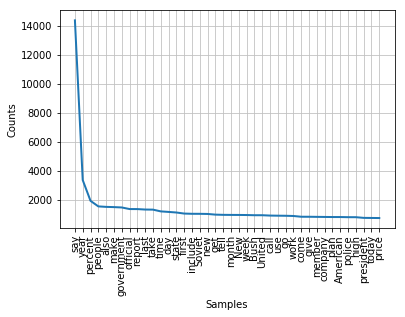

In [22]:
Freq=FreqDist(palabras)
FreqDist(palabras).plot(40, cumulative=False)

In [5]:
#from itertools import groupby

#freq = {}
#for palabra in set(palabras):
#        freq[palabra] = palabras.count(palabra)

In [20]:
print('Tamaño del vocabulario: ' + str(len(Freq)))

Tamaño del vocabulario: 36374


In [7]:
#most_freq = sorted(freq.items(), key=lambda x: x[1], reverse=True)[0:500]
#print (most_freq)

### 3. Para las 500 palabras con más apariciones, calcular el par más asociado según la medida presentada.

In [27]:
# Se buscan los pares de palabras más asociados dentro de todo el texto 
from nltk.collocations import *
bigram_measures= nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(palabras,3)
finder.apply_freq_filter(3)
scored = finder.nbest(bigram_measures.pmi,20)
print(scored)

[('Cam', 'Ranh'), ('Chi', 'Chi'), ('Cordon', 'Bleu'), ('Croatia', 'Slovenia'), ('Doo', 'hwan'), ('Gazeta', 'Wyborcza'), ('Guess', 'Jeans'), ('JNB', 'Exploration'), ('Novaya', 'Zemlya'), ('Nueva', 'Vizcaya'), ('Palmieri', 'Billig'), ('Palo', 'Alto'), ('Tan', 'Ching'), ('Term', 'Strategy'), ('Yasuhiro', 'Nakasone'), ('Yom', 'Kippur'), ('avant', 'garde'), ('Adventures', 'Munchausen'), ('Coeur', "d'Alene"), ('Coral', 'Gables')]


## Información Léxica
Bajar de Project Gutenberg el libro de Darwin ON THE ORIGIN OF SPECIES.


### 1. Procesar el texto, tokenizando eliminando signos de puntuación.

In [2]:
# descargamos el libro
url = "http://www.gutenberg.org/cache/epub/1228/pg1228.txt"
response = request.urlopen(url)
raw = response.read().decode('utf8')

In [3]:
#se recortará el documento de forma tal que sólo quede el contenido de los distintos capítulos
inicio=raw.rfind("INTRODUCTION.") #aquí comenzaría
fin=raw.rfind("INDEX.") #aquí terminaría

#se tokenizará el texto y se eliminarán los signos de puntuación
tokenizer = RegexpTokenizer(r'\w+')
texto = tokenizer.tokenize(raw[inicio:fin])

### 2. Siguiendo el artículo de la sección, calcular la autocorrelación para estimar la distribución de la palabra a lo largo del texto.

In [4]:
def get_words_index(texto, words):
    """ texto: lista de palabras
        words: lista de palabras a buscar en texto
        
        Para el texto, devolver un diccionario
        {word: [indice]} donde word es cada una de los elementos
        de words e [indice] es una lista de posiciones en donde ocurre
        la palabra en el texto
    """
    
    r = {w: [] for w in words}
    i = 1
    for palabra in texto:
        if palabra in words:
            r[palabra].append(i)
        i = i + 1
    
    return r

In [5]:
def P(p_index, t):
    """ p_index: posiciones de la palabra en el texto
        t: posicion en el texto para el calculo de p
    """
    sigma = 50
    c = 1 / np.sqrt(2 * np.pi)
    z = -1/(2*sigma*sigma)
    
    r = c*np.sum(np.exp(np.multiply(np.square(np.subtract(t, p_index)), z)))
    
    return r

In [6]:
# Calculo los P para cada posicion del texto para cada palabra

index = get_words_index(texto, ['plants', 'instinct', 'for'])

N = len(texto)
p = {w: [] for w in index.keys()}

for word in index.keys():
    for t in range(1, N+1):
        p[word].append(P(index[word], t))

In [7]:
def c(pw, tau):
    """pw: P aplicado a todas las posiciones de un texto para una palabra
    
        devuelve la autocorrelacion normalizada 
    """
    N = len(pw)
    Epptau = np.mean(np.multiply(pw[0:N-tau], pw[tau:]))
    EpEptau = np.mean(pw) * np.mean(pw[tau:])
    return (Epptau - EpEptau) / (np.mean(np.square(pw)) - (np.square(np.mean(pw)))) 

In [8]:
words = ['plants', 'instinct', 'for']
cs = {w: [] for w in words}
dominio = np.arange(0, 10000, 10)

for palabra in words:
    for tau in dominio:
        cs[palabra].append(c(p[palabra], tau))

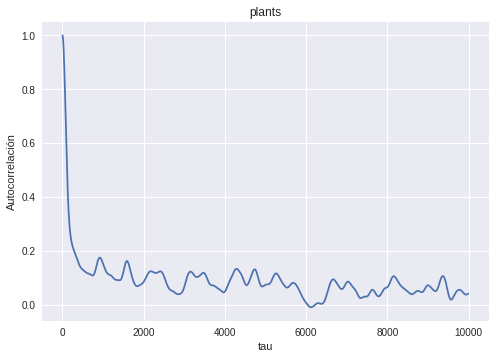

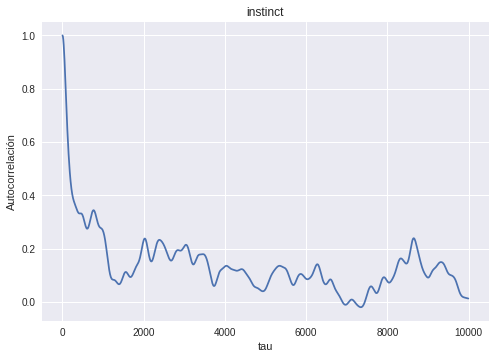

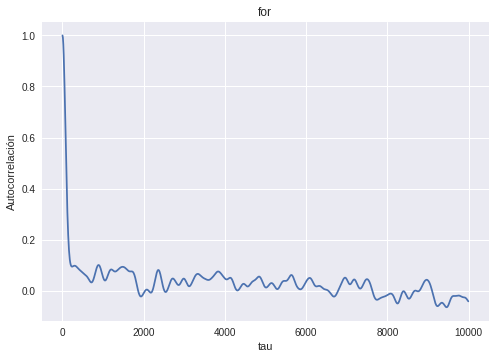

In [9]:
for palabra in words:
    plt.plot(dominio, cs[palabra])
    plt.title(palabra)
    plt.ylabel("Autocorrelación")
    plt.xlabel("tau")
    plt.show()

Al igual que se muestra en el paper, la palabra 'for', que a diferencia de los otros dos ejemplos, 'plants' y 'instinct', tiene un uso homogéneo, es decir, su uso no se confina a secciones particulares, si no que se extiende a través del texto, produce un coeficiente de auto correlación cercano a 0 para todo tau no demasiado pequeño.

### 3. Calcular la entropı́a de una selección de 100 palabras que abarquen el rango de frecuencia de aparición en el libro, es decir elegir palabras que son muy frecuentes y otras de baja frecuencia.

Primero procesamos el texto para elegir las 100 palabras. Para eso computamos la frecuencia de cada palabra.

In [10]:
import operator
freq=FreqDist(texto)


#palabras ordenadas por frecuencia, en orden decreciente
freq_palabras = sorted(freq.items(), key=operator.itemgetter(1), reverse=True)

# dividimos las frecuencias en 5 secciones de igual tamaño
# y tomamos las 20 palabras mas frecuentes dentro de cada
# seccion, de esta manera cubrimos el rango de apariciones
elegidas = []
step = int(len(freq_palabras)/5)
i = step
j = 0
while i < len(freq_palabras):
    seccion = freq_palabras[j:i]
    elegidas = elegidas + seccion[0:20]
    j = i
    i = i + step

print([e[0] for e in elegidas])



['the', 'of', 'and', 'in', 'to', 'a', 'that', 'have', 'be', 'as', 'species', 'is', 'by', 'which', 'or', 'are', 'on', 'from', 'for', 'I', 'statements', 'identically', 'aphides', 'yellow', 'score', 'They', 'bring', 'quality', 'centuries', 'inferior', 'whence', 'reptiles', 'matter', 'asserted', 'planes', 'discover', 'geese', 'cautious', 'Finally', 'force', 'fragment', 'strawberry', 'satisfied', '2', 'fundamentally', 'you', 'isthmus', 'prototype', 'Very', 'singing', 'epidemics', 'appreciable', 'heard', 'fleetness', 'yard', 'familiarity', 'chains', 'conception', 'teleostean', 'grew', 'dissected', 'hotter', 'pony', 'Breeders', 'terrier', 'gape', 'THEIR', 'retrograde', 'dusted', 'mineralogical', 'pointers', 'mammiferous', 'tabulated', 'absurd', 'satisfaction', 'kitchen', 'mottled', 'longiflora', 'Northern', 'prevailing', 'bug', 'spike', 'plum', 'wattles', 'Schlegel', '46', 'ponies', 'idle', 'Horse', 'reckon', 'obligations', 'Annual', 'Paradise', 'dust', 'extracts', 'ramifications', 'DEGREE', 

Ahora calculamos la entropía de cada palabra usando las definiciones del paper correspondiente a la sección.

In [11]:
step = int(len(texto)/64)
entropias = {k[0]: [] for k in elegidas}

for palabra, n in elegidas:
    H = 0
    for j in range(1, 65): #calculo de la entropia, uso P=64 como en el paper
        inicio = (j-1)*step
        fin = j*step
        seccion = texto[inicio:fin]
        freq_seccion = FreqDist(seccion)
        nj = freq_seccion[palabra]
        if nj != 0:
            H -= (nj/n)*np.log2(nj/n)
        else:
            H -= 0 # cuando la palabra no esta en esta 
                    # seccion, sumo 0
        
    entropias[palabra] = H

In [12]:
print('palabras    entropias')

for p, e in sorted(entropias.items(), key=operator.itemgetter(1), reverse=True):
    print(p+'\t\t'+str(e))

palabras    entropias
of		5.98808799664
the		5.98620311461
and		5.98140858867
to		5.97414090545
that		5.97240207255
in		5.96538308119
a		5.95325223313
which		5.94253031432
or		5.93870887396
have		5.93822062003
as		5.93301980177
by		5.92182933719
be		5.92051812918
is		5.9175311993
for		5.91548470476
are		5.91100308113
from		5.89878309756
on		5.88092665568
I		5.81223938987
species		5.70248334674
whence		3.32192809489
Finally		3.32192809489
They		3.32192809489
statements		3.32192809489
identically		3.12192809489
reptiles		3.12192809489
matter		3.12192809489
asserted		3.12192809489
score		3.12192809489
bring		2.92192809489
quality		2.92192809489
discover		2.92192809489
force		2.92192809489
cautious		2.92192809489
inferior		2.72192809489
centuries		2.52192809489
geese		2.04643934467
yellow		1.84643934467
appreciable		1.58496250072
fragment		1.58496250072
fundamentally		1.58496250072
you		1.58496250072
heard		1.58496250072
Very		1.58496250072
isthmus		1.58496250072
familiarity		1.58496250072

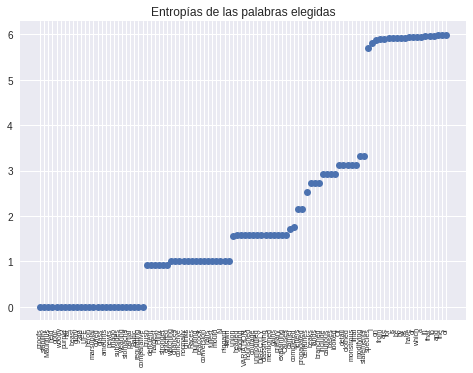

In [90]:
entropias_ord = sorted(entropias.items(), key=operator.itemgetter(1))
y = [e[1] for e in entropias_ord]
x = range(0, 100)
x_labels = [e[0] for e in entropias_ord]

fig, ax = plt.subplots(1,1) 
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation='vertical', fontsize=7)
ax.plot(x,y, 'o')
plt.title("Entropías de las palabras elegidas")
plt.show()

In [75]:
print("5 Palabras con mayor entropía:")
print()
for p, e in list(reversed(entropias_ord))[0:5]:
    print(p+'  '+str(e))

5 Palabras con mayor entropía:

of  5.98808799664
the  5.98620311461
and  5.98140858867
to  5.97414090545
that  5.97240207255


In [76]:
print("5 Palabras con menor entropía:")
print()
for p, e in list(entropias_ord)[0:5]:
    print(p+'  '+str(e))

5 Palabras con menor entropía:

proofs  0.0
stability  0.0
Mauritius  0.0
held  0.0
optic  0.0


### 4. Calcular la entropı́a de las palabras seleccionadas anteriormente, randomizando su posición en el texto. Comparar con los resultados del punto anterior.

In [78]:
from random import randint

first = lambda x: [elem[0] for elem in x]

step = int(len(texto)/64)
entropias_rnd = {k[0]: [] for k in elegidas}
contador = {k[0]: k[1] for k in freq_palabras if k[0] in first(elegidas)}
for palabra, n in elegidas:
    H = 0
    for j in range(0, 64): #calculo de la entropia
        if j < 63:
            nj = randint(0, contador[palabra])
        else:
            if contador[palabra] != 0:
                nj = contador[palabra]
        
        contador[palabra] -= nj
        
        if nj != 0:
            H -= (nj/n)*np.log2(nj/n)
        else:
            H -= 0 # cuando la palabra no esta en esta 
                    # seccion, sumo 0
        
    entropias_rnd[palabra] = H



In [81]:
print('palabras    entropias')

for p, e in sorted(entropias_rnd.items(), key=operator.itemgetter(1), reverse=True):
    print(p+'\t\t'+str(e))

palabras    entropias
completed		2.72192809489
from		2.29755041962
that		2.19956671294
species		2.1404670094
I		2.1107021967
a		2.08694279447
letters		2.04643934467
final		1.96096404744
of		1.84009434816
have		1.81279466907
be		1.81057335589
singing		1.58496250072
heron		1.58496250072
Causes		1.58496250072
in		1.57325786889
bases		1.57095059445
and		1.48578502252
detail		1.48547529723
monstrous		1.48547529723
to		1.4797345344
for		1.47281151401
by		1.41270431916
beaks		1.37095059445
or		1.36100057123
branched		1.36096404744
as		1.0128506131
Mauritius		1.0
chances		1.0
conceive		1.0
Races		1.0
hunting		1.0
peacock		1.0
modifying		1.0
mould		1.0
stomachs		1.0
N		1.0
niggard		1.0
flown		1.0
include		0.970950594455
carrier		0.970950594455
clothed		0.970950594455
looked		0.970950594455
union		0.921928094887
VARIATION		0.918295834054
DIRECTLY		0.918295834054
classifying		0.918295834054
mentioned		0.918295834054
Pliny		0.918295834054
gains		0.918295834054
primary		0.918295834054
stronger		0.9

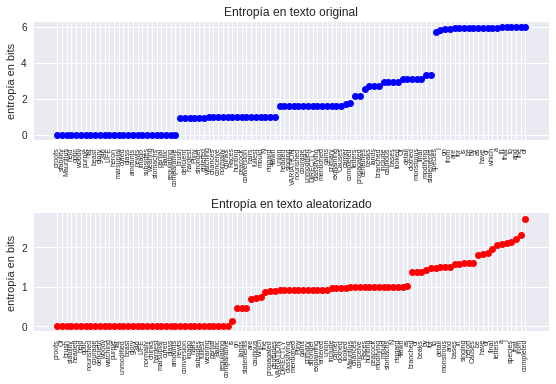

In [123]:
entropias_rnd_ord = sorted(entropias_rnd.items(), key=operator.itemgetter(1))
y_rnd = [e[1] for e in entropias_rnd_ord]
x = range(0, 100)
x_rnd_labels = [e[0] for e in entropias_rnd_ord]

_, ax = plt.subplots(nrows=2)

ax[0].set_title("Entropía en texto original")
ax[0].set_xticks(x)
ax[0].set_xticklabels(x_labels, rotation='vertical', fontsize=7)
ax[0].set_ylabel("entropía en bits")
ax[0].plot(x,y,'bo') # entropias sin aleatorizar

ax[1].set_title("Entropía en texto aleatorizado")
ax[1].set_xticks(x)
ax[1].set_xticklabels(x_rnd_labels, rotation='vertical', fontsize=7)
ax[1].set_ylabel("entropía en bits")
ax[1].plot(x,y_rnd, 'ro') # entropias luego de aletorizar

plt.tight_layout()

#plt.ylabel("entropía en bits")
#plt.xlabel("palabras")
plt.show()

Como podemos ver, las palabras tienen una entropía menor cuando se definen las pocisiones de manera aleatoria. 

Es interesante notar que la media de la entropía de las palabras elegidas tomando su posiciòn de manera aleatoria es menor que la entropía con las posiciones originales, esto puede ser porque al aleatorizar las pocisiones se destruye la estructura del texto. Comparamos las medias usando test de hipótesis, lo que confirmó nuestra suposición

In [130]:
import scipy
_, p = scipy.stats.mannwhitneyu(y, y_rnd)
print('pvalor Mann-Whitneyu '+ str(p))

_, p = scipy.stats.ranksums(y, y_rnd)
print('pvalor ranksums '+ str(p))

pvalor Mann-Whitneyu 1.07418197682e-06
pvalor ranksums 3.20695912102e-06


In [125]:
print("5 Palabras con mayor entropía (original):")
print()
for p, e in list(reversed(entropias_ord))[0:5]:
    print(p+'  '+str(e))

5 Palabras con mayor entropía (original):

of  5.98808799664
the  5.98620311461
and  5.98140858867
to  5.97414090545
that  5.97240207255


In [124]:
print("5 Palabras con mayor entropía (aleatoria):")
print()
for p, e in list(reversed(entropias_rnd_ord))[0:5]:
    print(p+'  '+str(e))

5 Palabras con mayor entropía (aleatoria):

completed  2.72192809489
from  2.29755041962
that  2.19956671294
species  2.1404670094
I  2.1107021967


En el resultado anterior notamos que las palabras con mayor entropía cambiaron. 

En el texto original las palabras con mayor entropía son palabras de uso más bien sintáctico, distribuidas en todo texto del idioma de forma homogénea, mientras que al mover de forma aleatoria las posiciones de las palabras, esto no siempre es cierto.

## Word embeddings, distancia semántica y WordNet
1. Utilizando el test WordSim3531, comparar el rendimiento entre LSA y Word2Vec2.
2. Comparar los distintos word embeddings con las medidas definidas en WordNet. 

Para la comparación, a partir de los pares de palabras definidos en el test de WordSim propuesto, que determina un score de similitud para cada par, el objetivo es armar un score usando las otras herramientas.
Armamos un score de similitud con LSA, con word2vec, y con el de wordnet que ya viene entrenado, para los mismos pares de palabras y realizamos un gráfico para cada uno. Realizamos algunos gráficos combinados para observar los scores.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Obtenemos las palabras de wordsim con su score
df1 = pd.read_csv('combined.csv')
#pares de palabras
palabras = df1.loc[:,['Word 1', 'Word 2']].values
#indice 
wn = list(range(0, len(palabras)))

#primeras 15
df1[:15]

,Word 1,Word 2,Human (mean)
0,love,sex,6.77
1,tiger,cat,7.35
2,tiger,tiger,10.00
3,book,paper,7.46
4,computer,keyboard,7.62
5,computer,internet,7.58
6,plane,car,5.77
7,train,car,6.31
8,telephone,communication,7.50
9,television,radio,6.77


In [3]:
#score de wordsim
wx1 = df1.loc[:,['Human (mean)']]

In [4]:
#valores entre 1 y 0
wx1 = np.concatenate(list(map(lambda n: n/10, df1.loc[:,['Human (mean)']].values)))
wx1[:15]

array([ 0.677,  0.735,  1.   ,  0.746,  0.762,  0.758,  0.577,  0.631,
        0.75 ,  0.677,  0.742,  0.685,  0.619,  0.592,  0.7  ])

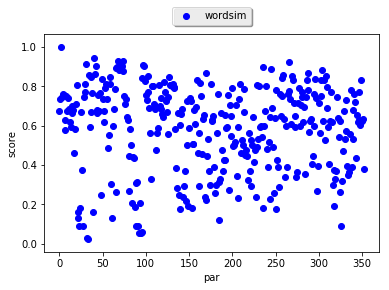

In [5]:
plt.figure()
plt.scatter(wn, wx1, label = "wordsim", color='b')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.xlabel('par')
plt.ylabel('score')

plt.show()
plt.close()

In [8]:
#Para los mismos pares de palabras utilizamos desde el sitio http://lsa.colorado.edu/ 
#la herramienta web http://lsa.colorado.edu/cgi-bin/LSA-pairwise.html
#para generar un archivo lsaweb_out.csv, con el resultado generado con 'Latent Semantic Analysis - Pairwise Comparison'
#tasaALL college - General_Reading_up_to_1st_year_college (300 factors)
df2 = pd.read_csv('lsaweb_out.csv')
df2[:15]

,Text1,Text2,score
0,love,sex,0.22
1,tiger,cat,0.45
2,tiger,tiger,1.00
3,book,paper,0.11
4,computer,keyboard,0.77
5,computer,internet,NaN
6,plane,car,0.03
7,train,car,0.33
8,telephone,communication,0.49
9,television,radio,0.76


In [9]:
#Si el termino no se encuentra, entonces el score es NaN:
#Can't find any terms from text: 'internet'
#Can't find any terms from text: 'rook'
#Can't find any terms from text: 'Maradona'
#Can't find any terms from text: 'Arafat'
#Can't find any terms from text: 'Arafat'
#Can't find any terms from text: 'Arafat'
#Can't find any terms from text: 'archive' 

In [10]:
#score de Latent Semantic Analysis - Pairwise Comparison
wx2 = df2.loc[:,['score']]

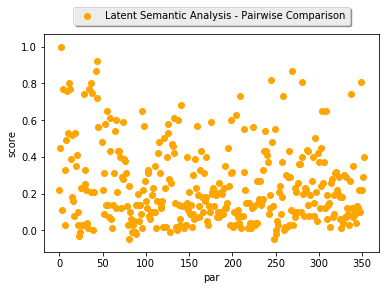

In [11]:
plt.figure()
plt.scatter(wn, wx2, label = "Latent Semantic Analysis - Pairwise Comparison", color='orange')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.xlabel('par')
plt.ylabel('score')
plt.show()
plt.close()

In [13]:
import gensim

In [17]:
#word2vec utilizando GoogleNews-vectors-negative300 .bin.gz.
#descargado de https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download
#El limite es por el uso de la memoria
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

In [18]:
#Encabezado
pd.DataFrame(columns=['Text1','Text2','score']).to_csv('word2vec_out.csv', columns=['Text1','Text2','score'], index =False)

df3 = pd.DataFrame({})

for par in palabras:    
    score = model.similarity(par[0], par[1])
    serie = pd.Series([par[0], par[1], score])
    df3=df3.append(serie, ignore_index=True)
    #print(par[0], par[1], score)
    
df3.to_csv('word2vec_out.csv', mode='a', header=False, index =False) 


In [19]:
df3 = pd.read_csv('word2vec_out.csv')
df3[:15]

,Text1,Text2,score
0,love,sex,0.263938
1,tiger,cat,0.517296
2,tiger,tiger,1.000000
3,book,paper,0.363463
4,computer,keyboard,0.396392
5,computer,internet,0.406862
6,plane,car,0.377970
7,train,car,0.340256
8,telephone,communication,0.332185
9,television,radio,0.611497


In [20]:
#score de word2vec
wx3 = df3.loc[:,['score']]

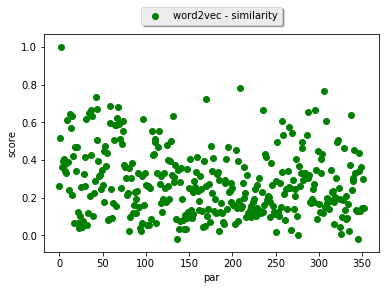

In [21]:
plt.figure()
plt.scatter(wn, wx3, label = "word2vec - similarity", color='g')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.xlabel('par')
plt.ylabel('score')
plt.show()
plt.close()

In [22]:
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [23]:
#Encabezado
pd.DataFrame(columns=['Text1','Text2','score']).to_csv('wordnet_out.csv', columns=['Text1','Text2','score'], index =False)

df4 = pd.DataFrame({})

for par in palabras:
    try:
        sp1 = wordnet.synset("{}.n.01".format(par[0]))
        sp2 = wordnet.synset("{}.n.01".format(par[1]))
        score = sp1.wup_similarity(sp2) #Wu-Palmer Similarity
    except Exception:
        score='N/A'

    serie = pd.Series([par[0], par[1], score])
    df4=df4.append(serie, ignore_index=True)
    
df4.to_csv('wordnet_out.csv', mode='a', header=False, index =False) 

In [24]:
#Si el termino no se encuentra, entonces el score es NaN:
#media radio
#stock live
#Maradona football
#drink eat
#street children
#media trading
#media gain
#investor earning
#fighting defeating

In [25]:
df4 = pd.read_csv('wordnet_out.csv')
df4[:15]

,Text1,Text2,score
0,love,sex,0.153846
1,tiger,cat,0.545455
2,tiger,tiger,0.750000
3,book,paper,0.250000
4,computer,keyboard,0.823529
5,computer,internet,0.631579
6,plane,car,0.666667
7,train,car,0.666667
8,telephone,communication,0.133333
9,television,radio,0.900000


In [26]:
#score de wordnet
wx4 = df4.loc[:,['score']]

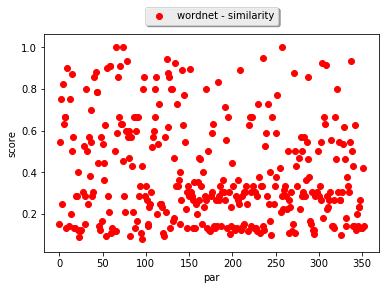

In [27]:
plt.figure()
plt.scatter(wn, wx4, label = "wordnet - similarity", color='r')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.xlabel('par')
plt.ylabel('score')
plt.show()
plt.close()

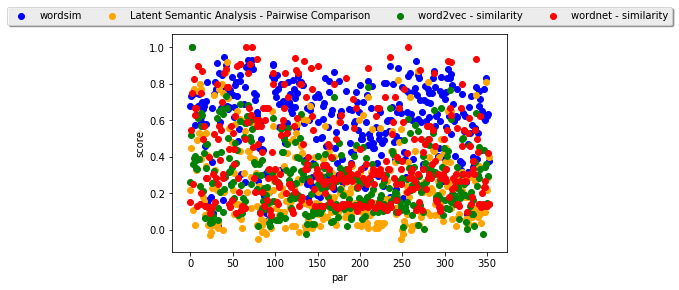

In [28]:
#combinados
plt.figure()
plt.scatter(wn, wx1, label = "wordsim", color='b')
plt.scatter(wn, wx2, label = "Latent Semantic Analysis - Pairwise Comparison", color='orange')
plt.scatter(wn, wx3, label = "word2vec - similarity", color='g')
plt.scatter(wn, wx4, label = "wordnet - similarity", color='r')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.xlabel('par')
plt.ylabel('score')
plt.show()
plt.close()

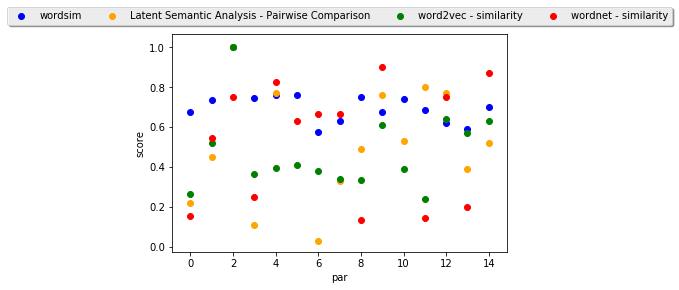

In [29]:
#Comparo solo los primeros
plt.figure()
plt.scatter(wn[:15], wx1[:15], label = "wordsim", color='b')
plt.scatter(wn[:15], wx2[:15], label = "Latent Semantic Analysis - Pairwise Comparison", color='orange')
plt.scatter(wn[:15], wx3[:15], label = "word2vec - similarity", color='g')
plt.scatter(wn[:15], wx4[:15], label = "wordnet - similarity", color='r')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.xlabel('par')
plt.ylabel('score')
plt.show()
plt.close()

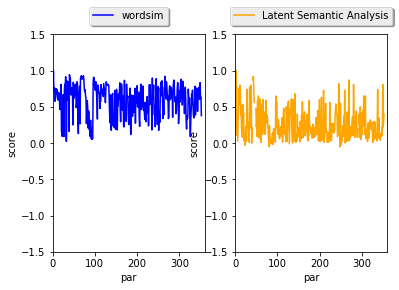

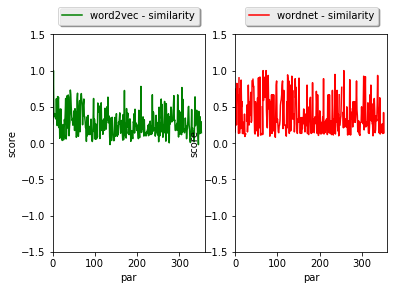

In [30]:
#Diferentes gráficos con todos los scores
plt.figure()
plt.subplot(1,2,1)
plt.plot(wn, wx1, label = "wordsim", color='b')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.axis([0,360,-1.5,1.5])
plt.xlabel('par')
plt.ylabel('score')

plt.subplot(1,2,2)
plt.plot(wn, wx2, label = "Latent Semantic Analysis",  color='orange')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.axis([0,360,-1.5,1.5])
plt.xlabel('par')
plt.ylabel('score')

plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.plot(wn, wx3, label = "word2vec - similarity",  color='g')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.axis([0,360,-1.5,1.5])
plt.xlabel('par')
plt.ylabel('score')

plt.subplot(1,2,2)
plt.plot(wn, wx4, label = "wordnet - similarity", color='r')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.axis([0,360,-1.5,1.5])
plt.xlabel('par')
plt.ylabel('score')

plt.show()
plt.close()

In [31]:
#Limpieza y normalizacion, sobre los datos
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

In [32]:
data = [wx1, np.concatenate(list(wx2.values)), np.concatenate(list(wx3.values)), np.concatenate(list(wx4.values))]
data

[array([ 0.677,  0.735,  1.   ,  0.746,  0.762,  0.758,  0.577,  0.631,
         0.75 ,  0.677,  0.742,  0.685,  0.619,  0.592,  0.7  ,  0.662,
         0.681,  0.462,  0.581,  0.708,  0.808,  0.162,  0.131,  0.092,
         0.181,  0.669,  0.373,  0.092,  0.746,  0.812,  0.773,  0.915,
         0.031,  0.023,  0.858,  0.592,  0.669,  0.846,  0.765,  0.162,
         0.944,  0.862,  0.903,  0.681,  0.663,  0.756,  0.673,  0.765,
         0.25 ,  0.838,  0.738,  0.619,  0.673,  0.792,  0.812,  0.735,
         0.488,  0.554,  0.846,  0.813,  0.304,  0.131,  0.596,  0.687,
         0.785,  0.265,  0.894,  0.896,  0.929,  0.883,  0.91 ,  0.887,
         0.902,  0.929,  0.879,  0.752,  0.71 ,  0.738,  0.646,  0.627,
         0.269,  0.446,  0.585,  0.5  ,  0.208,  0.442,  0.438,  0.185,
         0.308,  0.092,  0.315,  0.092,  0.054,  0.208,  0.054,  0.062,
         0.842,  0.908,  0.904,  0.827,  0.757,  0.729,  0.85 ,  0.773,
         0.688,  0.565,  0.331,  0.8  ,  0.8  ,  0.708,  0.685, 

In [33]:
#Reemplazo NaN
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(data)
data1 = imp.transform(data)
data1

array([[ 0.677     ,  0.735     ,  1.        , ...,  0.625     ,
         0.634     ,  0.378     ],
       [ 0.22      ,  0.45      ,  1.        , ...,  0.22      ,
         0.29      ,  0.4       ],
       [ 0.26393773,  0.51729619,  1.        , ...,  0.1452283 ,
         0.29663557,  0.14309331],
       [ 0.15384615,  0.54545455,  0.75      , ...,  0.13333333,
         0.42105263,  0.14285714]])

In [34]:
#transformo los datos
scaler = StandardScaler()
scaler.fit(data1)
StandardScaler(copy=True, with_mean=True, with_std=True)
www = scaler.transform(data1)
www

array([[ 1.7000729 ,  1.63628685,  0.57735027, ...,  1.70833247,
         1.60572447,  0.90876304],
       [-0.53054533, -1.05835958,  0.57735027, ..., -0.3022905 ,
        -0.86486452,  1.08725032],
       [-0.31608515, -0.42208085,  0.57735027, ..., -0.6734947 ,
        -0.81720819, -0.99704868],
       [-0.85344243, -0.15584642, -1.73205081, ..., -0.73254727,
         0.07634824, -0.99896468]])

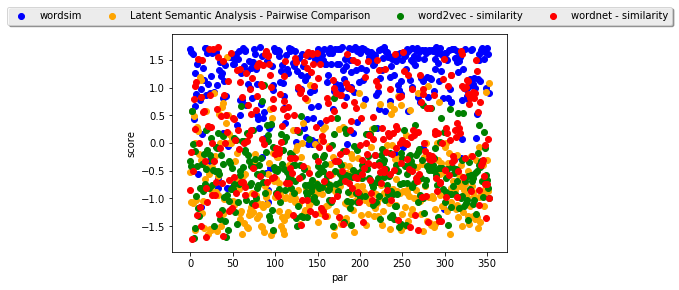

In [35]:
#Diferentes gráficos para comparar
plt.figure()
plt.scatter(wn, www[0], label = "wordsim", color='b')
plt.scatter(wn, www[1], label = "Latent Semantic Analysis - Pairwise Comparison", color='orange')
plt.scatter(wn, www[2], label = "word2vec - similarity", color='g')
plt.scatter(wn, www[3], label = "wordnet - similarity", color='r')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.xlabel('par')
plt.ylabel('score')
plt.show()
plt.close()

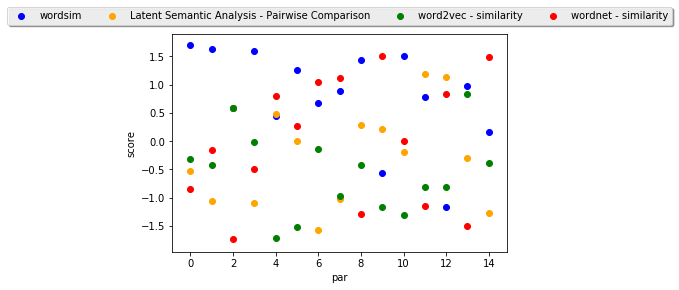

In [36]:
plt.figure()
plt.scatter(wn[:15], www[0][:15], label = "wordsim", color='b')
plt.scatter(wn[:15], www[1][:15], label = "Latent Semantic Analysis - Pairwise Comparison", color='orange')
plt.scatter(wn[:15], www[2][:15], label = "word2vec - similarity", color='g')
plt.scatter(wn[:15], www[3][:15], label = "wordnet - similarity", color='r')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.xlabel('par')
plt.ylabel('score')
plt.show()
plt.close()

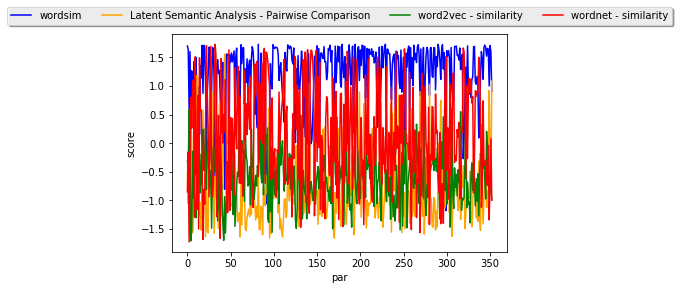

In [37]:
#Otra forma
plt.figure()
plt.plot(wn, www[0], label = "wordsim", color='b')
plt.plot(wn, www[1], label = "Latent Semantic Analysis - Pairwise Comparison", color='orange')
plt.plot(wn, www[2], label = "word2vec - similarity", color='g')
plt.plot(wn, www[3], label = "wordnet - similarity", color='r')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.xlabel('par')
plt.ylabel('score')
plt.show()
plt.close()

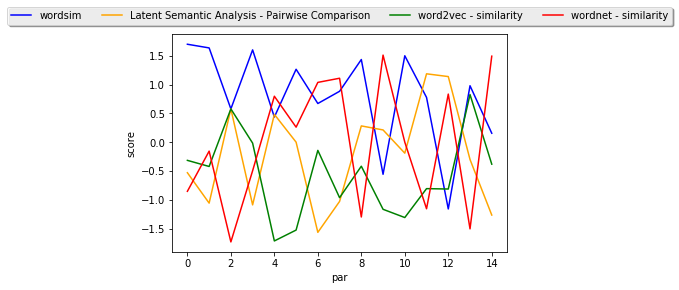

In [40]:
plt.figure()
plt.plot(wn[:15], www[0][:15], label = "wordsim", color='b')
plt.plot(wn[:15], www[1][:15], label = "Latent Semantic Analysis - Pairwise Comparison", color='orange')
plt.plot(wn[:15], www[2][:15], label = "word2vec - similarity", color='g')
plt.plot(wn[:15], www[3][:15], label = "wordnet - similarity", color='r')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.xlabel('par')
plt.ylabel('score')
plt.show()
plt.close()

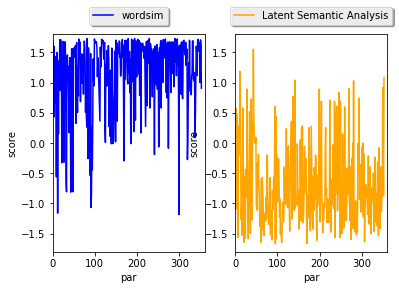

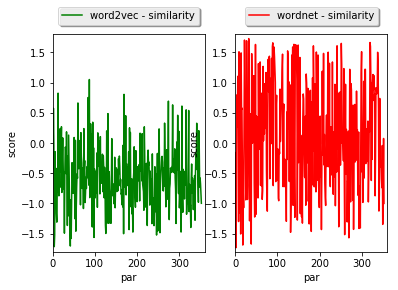

In [41]:
#Por separado
plt.figure()
plt.subplot(1,2,1)
plt.plot(wn, www[0], label = "wordsim", color='b')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.axis([0,360,-1.8,1.8])
plt.xlabel('par')
plt.ylabel('score')

plt.subplot(1,2,2)
plt.plot(wn, www[1], label = "Latent Semantic Analysis",  color='orange')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.axis([0,360,-1.8,1.8])
plt.xlabel('par')
plt.ylabel('score')

plt.show()

plt.figure()
plt.subplot(1,2,1)
plt.plot(wn, www[2], label = "word2vec - similarity",  color='g')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.axis([0,360,-1.8,1.8])
plt.xlabel('par')
plt.ylabel('score')

plt.subplot(1,2,2)
plt.plot(wn, www[3], label = "wordnet - similarity", color='r')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),fancybox=True, shadow=True, ncol=6)
plt.axis([0,360,-1.8,1.8])
plt.xlabel('par')
plt.ylabel('score')

plt.show()
plt.close()

A partir de los scores con las diferentes herramientas y los gráficos propuestos, entendemos que para el conjunto de palabras elegido wordsim muestra en general un mayor score de similitud, principalmente sobre la puntuación con LSA y word2vec. 
Por otra parte, los resultados de la puntuación con WordNet son más espacidos, con score en todo el rango, para los mismos pares de palabras

Enlace al trabajo:
https://github.com/barbeiton/tpscd/blob/master/tp6/tp6.ipynb


Para acceder al directorio, con los archivos generados:
https://github.com/barbeiton/tpscd/tree/master/tp6